In [8]:
# transfer learning using MobileNet-V3 large 

from tensorflow.keras import Model 
from tensorflow.keras.applications import MobileNetV3Large 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [9]:
trainPath = "G:/desktop/project/sweetClassification/sweetDataset/train"
ValidPath = "G:/desktop/project/sweetClassification/sweetDataset/validate"

In [10]:
trainGenerator = ImageDataGenerator(
    rotation_range=15 ,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0, 0.2)).flow_from_directory(trainPath, target_size=(320,320),batch_size=32)

ValidGenerator = ImageDataGenerator(
    rotation_range=15 ,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0, 0.2)).flow_from_directory(ValidPath, target_size=(320,320), batch_size=32)

Found 2083 images belonging to 9 classes.
Found 371 images belonging to 9 classes.


In [11]:
baseModel = MobileNetV3Large(weights= "imagenet", include_top=False)

C:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictionLayer = Dense(9, activation='softmax')(x)

In [ ]:
model = Model(inputs=baseModel.input , outputs=predictionLayer)
print(model.summary())

In [ ]:
# freeze the layers of the MobileNetV3 (already trained)
for layer in model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Compile
# Adjusting the learning rate
optimizer = Adam(learning_rate=0.0001)

# Adding ReduceLROnPlateau callback to dynamically adjust learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# train
history = model.fit(trainGenerator, validation_data=ValidGenerator, epochs=15, callbacks=[reduce_lr])

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems like model is overfitted we need to fine tune our model

In [13]:
# Add dropout and l2 regularization to dense layers
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)  # Adding dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)  # Adding dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)  # Adding dropout

predictionLayer = Dense(9, activation='softmax')(x)

model1 = Model(inputs=baseModel.input, outputs=predictionLayer)

# Freeze the layers of the MobileNetV3 (already trained)
for layer in model1.layers[:-8]:
    layer.trainable = False

# Compile
optimizer = Adam(learning_rate=0.0001)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with increased epochs
history1 = model1.fit(trainGenerator, validation_data=ValidGenerator, epochs=50, callbacks=[early_stopping])


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.1200 - loss: 13.9641 - val_accuracy: 0.3720 - val_loss: 12.8549
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2240 - loss: 12.7209 - val_accuracy: 0.4286 - val_loss: 11.8105
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3535 - loss: 11.6753 - val_accuracy: 0.4825 - val_loss: 10.8831
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3991 - loss: 10.8036 - val_accuracy: 0.5013 - val_loss: 10.1196
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4697 - loss: 9.9745 - val_accuracy: 0.5472 - val_loss: 9.3461
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5001 - loss: 9.2840 - val_accuracy: 0.5391 - val_loss: 8.8332
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5275 - loss: 8.7173 - val_accuracy: 0.6146 - val_loss: 8.2022
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5726 - loss: 8.1356 - val_accuracy: 0.

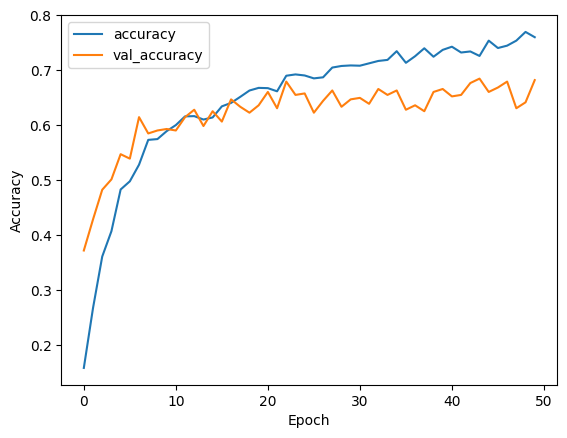

In [14]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

accordint to train and validation accuracy we need train our model upto 20 epochs only because further it goes to overfiting

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = model1.predict(ValidGenerator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = ValidGenerator.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Example: Extracting class-wise accuracy from confusion matrix
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
for i, accuracy in enumerate(class_accuracy):
    print(f"Class {i}: {accuracy:.2f}")

# Example: Generating a classification report
class_names = ['Balushahi', 'Besan ke Laddu', 'Jalebi', 'Kaju Katli', 'Modak', 'Peda', 'Rasgulla', 'Rasmalai', 'Soan Papdi']  
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Confusion Matrix:
[[ 3  8  9  5  3  2  3  5  3]
 [ 4  8  1  4  6  5  3  3  7]
 [ 3  8  4  6  7  2  2  6  4]
 [ 1  3  3  5  8  3  3 10  5]
 [ 6  3  6  6  5  2  7  4  3]
 [ 3  7  8  3  3  4  2  7  4]
 [ 3  4  3  3  8  1  7  6  6]
 [ 4  5  3  6  6  1  3  5  8]
 [ 6  2  6  6  7  3  8  2  1]]

Class-wise Accuracy:
Class 0: 0.07
Class 1: 0.20
Class 2: 0.10
Class 3: 0.12
Class 4: 0.12
Class 5: 0.10
Class 6: 0.17
Class 7: 0.12
Class 8: 0.02

Classification Report:
                precision    recall  f1-score   support

     Balushahi       0.09      0.07      0.08        41
Besan ke Laddu       0.17      0.20      0.18        41
        Jalebi       0.09      0.10      0.09        42
    Kaju Katli       0.11      0.12      0.12        41
         Modak       0.09      0.12      0.11        42
          Peda       0.17      0.10      0.13        41
      Rasgulla       0.18      0.17      0.18        41
      Rasmalai       0.10      0.12      0.11      

In [ ]:
As we can in classification report Balushahi and Soan Papdi class model failing to predict I don't have that much diverse data and 

### To impove model accuracy we can go with below steps

**Manual Inspection and Label Correction:** Review and correct mislabeled or ambiguous samples in your dataset. This can help ensure that the model learns from accurate and consistent data, reducing confusion between similar-looking sweets.\nnce.

**Ensemble Methods:** Combine predictions from multiple models (ensemble methods) to improve overall accuracy. This can involve training multiple models with different architectures or hyperparameters and averaging their predictions.



**Collect More Diverse Data:** If possible, collect more diverse data that captures a broader range of variations within each class of sweets. This can help the model learn more robust and discriminative features, leading to better classification performance.

In [ ]:
model1.save('sweet_model.keras')